# Capstone - Delivery-2
This dataset is part of the [Farming Systems Project](https://www.ars.usda.gov/northeast-area/beltsville-md-barc/beltsville-agricultural-research-center/sustainable-agricultural-systems-laboratory/docs/farming-systems-project/) at USDA, Beltsville MD.  This data is not available online on the USDA
 website but can be found on my [GitHub](https://github.com/mmtokay/DATA606/tree/master/datasets).


The data is split in two files, one that contains crop information and other with weather data.

Crop file:
* Crop - wheat, corn or soybean           
* GrowingSeason - year crop was cultivated 
* SystemName - crop management (traditional: NT and CT; organic: Org2, Org3 and Org6')    
* GrainYield - grain yield measured in kg/ha     
* PlantingDate - date seeds were planted  
* HarvestDate - date crop was harvested


Weather file:
* Year 
* Julian Day 
* Month
* Day
* Date
* avgtTempC - average temperature in C
* maxTempC - maximum temperature in C
* minTempC - minimum temperature in C
* maxHumPct - maximum humidity in %
* minHumPct - minimum humidity in %
* avgRadWm-2 - average radiation in w/m2
* meanWindMs-1 - mean wind in m/s
* PrecipitationMm - precipitation/snow melt in mm

# Exploratory Data Analysis (Preliminary)


In [3]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import warnings
import time

from datetime import datetime, timedelta
from __future__ import print_function

from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, RobustScaler, Normalizer, MinMaxScaler, StandardScaler, Binarizer
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.utils import shuffle
from time import time
from google.colab import drive
drive.mount('/content/drive')

warnings.simplefilter(action='ignore', category=FutureWarning)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Crop Data
Import crop data file.

In [4]:
data = pd.read_csv('/content/drive/My Drive/DATA606/Delivery-3/FSPGrainYieldsV3Clean.csv')
print(data.head())
print('\nData information.')
print(data.info())

  Crop  GrowingSeason SystemName  GrainYield PlantingDate HarvestDate
0  CRN           1996         NT     10488.0    5/23/1996  10/17/1996
1  CRN           1996         NT      9722.5    5/23/1996  10/17/1996
2  CRN           1996         NT     10008.0    5/23/1996  10/17/1996
3  CRN           1996         NT      8928.8    5/23/1996  10/17/1996
4  CRN           1996         CT     10985.3    5/23/1996  10/17/1996

Data information.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113 entries, 0 to 1112
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Crop           1113 non-null   object 
 1   GrowingSeason  1113 non-null   int64  
 2   SystemName     1113 non-null   object 
 3   GrainYield     1113 non-null   float64
 4   PlantingDate   1113 non-null   object 
 5   HarvestDate    1042 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 52.3+ KB
None


Data contains 6 columns and 1113 rows.

Data conversion:
*   Convert GrainYield to numeric.
*   Convert PlantingDate and HarvestDate to datetime.



In [0]:
# Convert from object to float64
data['GrainYield'] = pd.to_numeric(data.GrainYield, errors='coerce')

# Convert PlantingDate and HarvestDate from object to date
data['PlantingDate'] = pd.to_datetime(data.PlantingDate)
data['HarvestDate'] = pd.to_datetime(data.HarvestDate)

Let's check if there is any data missing on the dataset.  

In [6]:
data.isna().sum()

Crop              0
GrowingSeason     0
SystemName        0
GrainYield        0
PlantingDate      0
HarvestDate      71
dtype: int64

I don't have harvest date for 71 measurements.  Harvest date is not critical because often times the crop is not harvest as soon as the crop is mature.  It is important to know how long each crop takes to mature on average.  I will create a new column called weekDuration to calculate the week duration between planting date and harvest date.

In [7]:
# Calculate duration between PlantingDate and HarvestDate
data['weekDuration'] = data['HarvestDate'] - data['PlantingDate']
data['weekDuration'] = data['weekDuration']/np.timedelta64(1,'W')
print('\nCheck unique values for Crop, GrowingSeason and SystemName columns.\n')
print("Crop", data.Crop.unique())
print("\nGrowing Season", data.GrowingSeason.unique())
print("\nCrop Management Type", data.SystemName.unique())


Check unique values for Crop, GrowingSeason and SystemName columns.

Crop ['CRN' 'SOY' 'WHT']

Growing Season [1996 1997 1998 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016]

Crop Management Type ['NT' 'CT' 'Org2' 'Org3' 'Org6' 'ORG2' 'ORG3' 'ORG6']


There are duplicate values for SystemManagement because column values are case sensitive.  I will convert SystemName column to uppercase.

**Note:** There is no data for 1999 because it was a dry year and this experiment doesn't use irrigation, crops never matured.

In [8]:
data['SystemName'] = data['SystemName'].str.upper()
print("\nCrop Management Type", data.SystemName.unique())


Crop Management Type ['NT' 'CT' 'ORG2' 'ORG3' 'ORG6']


I will create a new column called SystemNameType for conventional and organic management.  These values will be generated from SystemName column. 

Conventional = NT and CT

Organic = ORG2, ORG3 and ORG6

In [9]:
# 1 for conventional
# 0 for organic
data['SystemNameType'] = ((data.SystemName == "NT") | (data.SystemName == "CT")).map({True:'1', False:'0'})
# Drop SystemName column
data.drop('SystemName', axis=1, inplace=True)
data.head()

,Crop,GrowingSeason,GrainYield,PlantingDate,HarvestDate,weekDuration,SystemNameType
0,CRN,1996,10488.0,1996-05-23,1996-10-17,21.0,1
1,CRN,1996,9722.5,1996-05-23,1996-10-17,21.0,1
2,CRN,1996,10008.0,1996-05-23,1996-10-17,21.0,1
3,CRN,1996,8928.8,1996-05-23,1996-10-17,21.0,1
4,CRN,1996,10985.3,1996-05-23,1996-10-17,21.0,1


I will separate the data by crop: corn, soybean and wheat and I will display basic statistics for each crop.

# Corn dataset - Statistics

In [10]:
data_corn = data.loc[data['Crop'] == "CRN"]
print(data_corn.describe(include="all"))
print('\nCorn Data Distribution by Year\n')
data_corn_grouped = data_corn.groupby(['GrowingSeason'], as_index=False).agg({'GrainYield': "count"})
print(data_corn_grouped.head())

       Crop  GrowingSeason  ...  weekDuration SystemNameType
count   390     390.000000  ...    370.000000            390
unique    1            NaN  ...           NaN              2
top     CRN            NaN  ...           NaN              0
freq    390            NaN  ...           NaN            234
first   NaN            NaN  ...           NaN            NaN
last    NaN            NaN  ...           NaN            NaN
mean    NaN    2006.376923  ...     21.583398            NaN
std     NaN       5.932697  ...      2.521325            NaN
min     NaN    1996.000000  ...     16.857143            NaN
25%     NaN    2002.000000  ...     19.428571            NaN
50%     NaN    2007.000000  ...     21.142857            NaN
75%     NaN    2011.000000  ...     23.285714            NaN
max     NaN    2016.000000  ...     28.571429            NaN

[13 rows x 7 columns]

Corn Data Distribution by Year

   GrowingSeason  GrainYield
0           1996          20
1           1997          16
2  

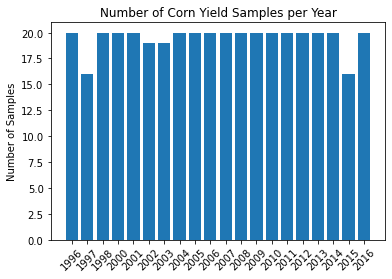

In [11]:
y_pos = np.arange(len(data_corn_grouped['GrowingSeason']))
plt.bar(y_pos, data_corn_grouped['GrainYield'], align='center')
plt.xticks(y_pos, data_corn_grouped['GrowingSeason'], rotation=45)
plt.ylabel('Number of Samples')
plt.title('Number of Corn Yield Samples per Year')
plt.show()

Corn Data Distribution by Crop Management Type

In [12]:
data_corn_sys_grouped = data_corn.groupby(['SystemNameType'], as_index=False).agg({'GrainYield': "count"})
data_corn_sys_grouped.head()

,SystemNameType,GrainYield
0,0,234
1,1,156


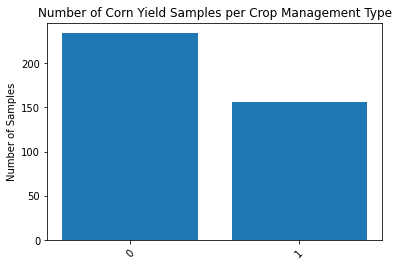

In [13]:
y_pos = np.arange(len(data_corn_sys_grouped['SystemNameType']))
plt.bar(y_pos, data_corn_sys_grouped['GrainYield'], align='center')
plt.xticks(y_pos, data_corn_sys_grouped['SystemNameType'], rotation=45)
plt.ylabel('Number of Samples')
plt.title('Number of Corn Yield Samples per Crop Management Type')
plt.show()

# Soybean dataset - Statistics

In [14]:
data_soy = data.loc[data['Crop'] == "SOY"]
print(data_soy.describe(include="all"))
print('\nSoybean Data Distribution by Year\n')
data_soy_grouped = data_soy.groupby(['GrowingSeason'], as_index=False).agg({'GrainYield': "count"})
print(data_soy_grouped.head())

       Crop  GrowingSeason  ...  weekDuration SystemNameType
count   500     500.000000  ...    465.000000            500
unique    1            NaN  ...           NaN              2
top     SOY            NaN  ...           NaN              1
freq    500            NaN  ...           NaN            273
first   NaN            NaN  ...           NaN            NaN
last    NaN            NaN  ...           NaN            NaN
mean    NaN    2006.768000  ...     21.113978            NaN
std     NaN       5.767556  ...      2.868903            NaN
min     NaN    1996.000000  ...     15.000000            NaN
25%     NaN    2002.000000  ...     19.142857            NaN
50%     NaN    2007.000000  ...     21.000000            NaN
75%     NaN    2012.000000  ...     23.428571            NaN
max     NaN    2016.000000  ...     26.857143            NaN

[13 rows x 7 columns]

Soybean Data Distribution by Year

   GrowingSeason  GrainYield
0           1996          20
1           1997          16


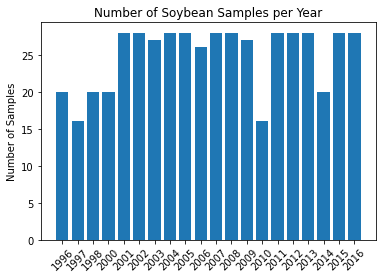

In [15]:
y_pos = np.arange(len(data_soy_grouped['GrowingSeason']))
plt.bar(y_pos, data_soy_grouped['GrainYield'], align='center')
plt.xticks(y_pos, data_soy_grouped['GrowingSeason'], rotation=45)
plt.ylabel('Number of Samples')
plt.title('Number of Soybean Samples per Year')
plt.show()

Soybean Data Distribution by Crop Management Type

In [16]:
data_soy_sys_grouped = data_soy.groupby(['SystemNameType'], as_index=False).agg({'GrainYield': "count"})
data_soy_sys_grouped.head()

,SystemNameType,GrainYield
0,0,227
1,1,273


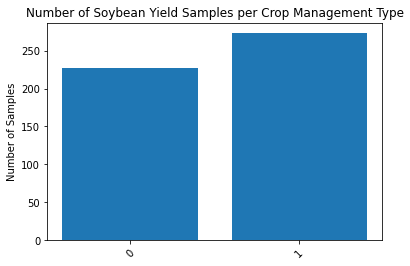

In [17]:
y_pos = np.arange(len(data_soy_sys_grouped['SystemNameType']))
plt.bar(y_pos, data_soy_sys_grouped['GrainYield'], align='center')
plt.xticks(y_pos, data_soy_sys_grouped['SystemNameType'], rotation=45)
plt.ylabel('Number of Samples')
plt.title('Number of Soybean Yield Samples per Crop Management Type')
plt.show()

# Wheat dataset - Statistics

In [18]:
data_wheat = data.loc[data['Crop'] == "WHT"]
print(data_wheat.describe(include="all"))
print('\nWheat Data Distribution by Year\n')
data_wheat_grouped = data_wheat.groupby(['GrowingSeason'], as_index=False).agg({'GrainYield': "count"})
print(data_wheat_grouped.head())

       Crop  GrowingSeason  ...  weekDuration SystemNameType
count   223     223.000000  ...    207.000000            223
unique    1            NaN  ...           NaN              2
top     WHT            NaN  ...           NaN              1
freq    223            NaN  ...           NaN            115
first   NaN            NaN  ...           NaN            NaN
last    NaN            NaN  ...           NaN            NaN
mean    NaN    2007.578475  ...     35.621808            NaN
std     NaN       6.094000  ...      1.901822            NaN
min     NaN    1997.000000  ...     31.428571            NaN
25%     NaN    2001.500000  ...     34.857143            NaN
50%     NaN    2009.000000  ...     35.428571            NaN
75%     NaN    2013.000000  ...     37.571429            NaN
max     NaN    2016.000000  ...     39.142857            NaN

[13 rows x 7 columns]

Wheat Data Distribution by Year

   GrowingSeason  GrainYield
0           1997           8
1           1998          16
2 

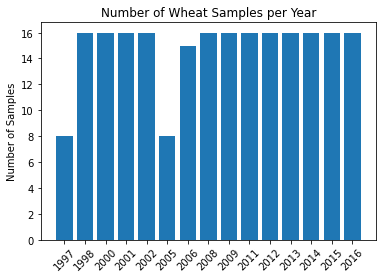

In [19]:
y_pos = np.arange(len(data_wheat_grouped['GrowingSeason']))
plt.bar(y_pos, data_wheat_grouped['GrainYield'], align='center')
plt.xticks(y_pos, data_wheat_grouped['GrowingSeason'], rotation=45)
plt.ylabel('Number of Samples')
plt.title('Number of Wheat Samples per Year')
plt.show()

Wheat Data Distribution by Crop Management Type

In [20]:
data_wheat_sys_grouped = data_wheat.groupby(['SystemNameType'], as_index=False).agg({'GrainYield': "count"})
data_wheat_sys_grouped.head()

,SystemNameType,GrainYield
0,0,108
1,1,115


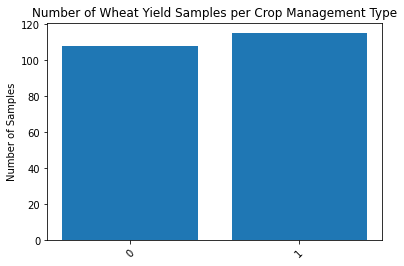

In [21]:
y_pos = np.arange(len(data_wheat_sys_grouped['SystemNameType']))
plt.bar(y_pos, data_wheat_sys_grouped['GrainYield'], align='center')
plt.xticks(y_pos, data_wheat_sys_grouped['SystemNameType'], rotation=45)
plt.ylabel('Number of Samples')
plt.title('Number of Wheat Yield Samples per Crop Management Type')
plt.show()

# Weather Data

Import weather data.

In [23]:
weather_data = pd.read_csv('/content/drive/My Drive/DATA606/Delivery-3/FSPWeather1996-2019V2.csv')
print(weather_data.head())
print('\nData information.\n')
print(weather_data.info())

   Year  JulianDay  Month  ...  avgRadWm-2 meanWindMs-1  PrecipitationMm
0  1996          1      1  ...        12.6          1.4              1.3
1  1996          2      1  ...         8.9          2.4              7.6
2  1996          3      1  ...        33.9          2.8             19.1
3  1996          4      1  ...        95.7          2.4              0.0
4  1996          5      1  ...       105.2          2.2              0.0

[5 rows x 13 columns]

Data information.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             8763 non-null   int64  
 1   JulianDay        8763 non-null   int64  
 2   Month            8763 non-null   int64  
 3    Day             8763 non-null   int64  
 4   Date             8763 non-null   object 
 5   avgtTempC        8728 non-null   float64
 6   maxTempC         8763 non-null   float6

Data contains 13 columns and 8762 rows. Convert Date to datetime.

In [0]:
weather_data['Date'] = pd.to_datetime(weather_data.Date)

# Weather Data - Statistics

In [25]:
weather_data.describe(include="all")

,Year,JulianDay,Month,Day,Date,avgtTempC,maxTempC,minTempC,maxHumPct,minHumPct,avgRadWm-2,meanWindMs-1,PrecipitationMm
count,8763.000000,8763.000000,8763.000000,8763.000000,8763,8728.000000,8763.000000,8763.000000,8763.000000,8763.000000,6796.000000,8750.000000,8763.000000
unique,NaN,NaN,NaN,NaN,8763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,2007-09-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,1996-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2019-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2007.498916,183.092320,6.522994,15.729773,NaN,13.059551,18.700260,7.228509,94.880158,47.487392,107.190830,1.999463,2.941006
std,6.921633,105.423565,3.449147,8.799551,NaN,9.363676,10.073274,9.275069,10.452223,18.361342,93.233499,1.366765,8.284377
min,1996.000000,1.000000,1.000000,1.000000,NaN,-13.600000,-9.570000,-20.100000,39.600000,8.500000,-0.019000,0.000000,0.000000
25%,2001.500000,92.000000,4.000000,8.000000,NaN,5.300000,10.600000,-0.500000,91.800000,33.800000,19.607500,1.128250,0.000000


Let's check if there is any data missing on the dataset.

In [26]:
weather_data.isna().sum()

Year                  0
JulianDay             0
Month                 0
 Day                  0
Date                  0
avgtTempC            35
maxTempC              0
minTempC              0
maxHumPct             0
minHumPct             0
avgRadWm-2         1967
meanWindMs-1         13
PrecipitationMm       0
dtype: int64

There are some data missing.  Let's plot each variable to check for anomalies in the data.

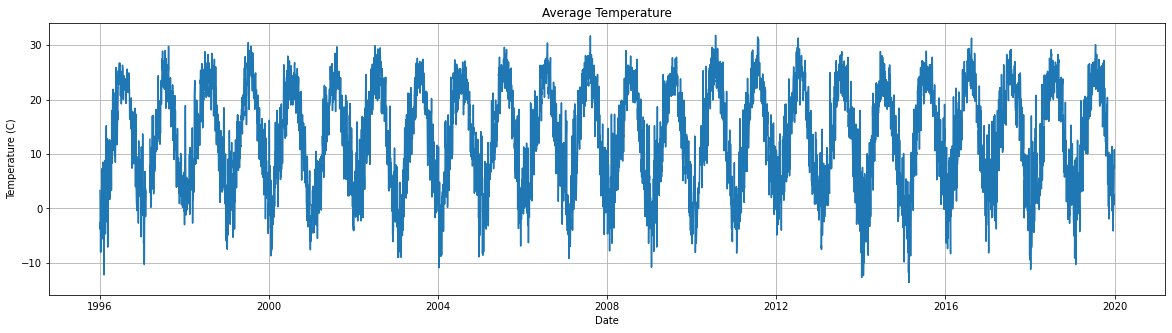

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(weather_data['Date'], weather_data['avgtTempC'])
ax.set(xlabel='Date', ylabel='Temperature (C)', title='Average Temperature')
ax.grid()
plt.show()

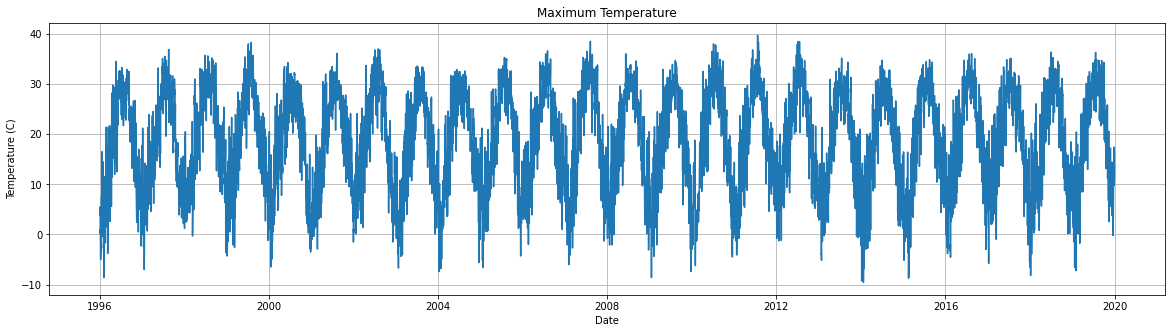

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(weather_data['Date'], weather_data['maxTempC'])
ax.set(xlabel='Date', ylabel='Temperature (C)', title='Maximum Temperature')
ax.grid()
plt.show()

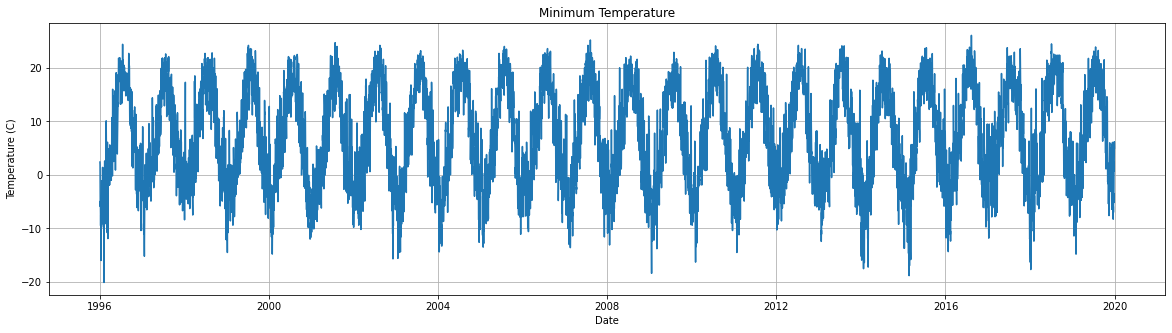

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(weather_data['Date'], weather_data['minTempC'])
ax.set(xlabel='Date', ylabel='Temperature (C)', title='Minimum Temperature')
ax.grid()
plt.show()

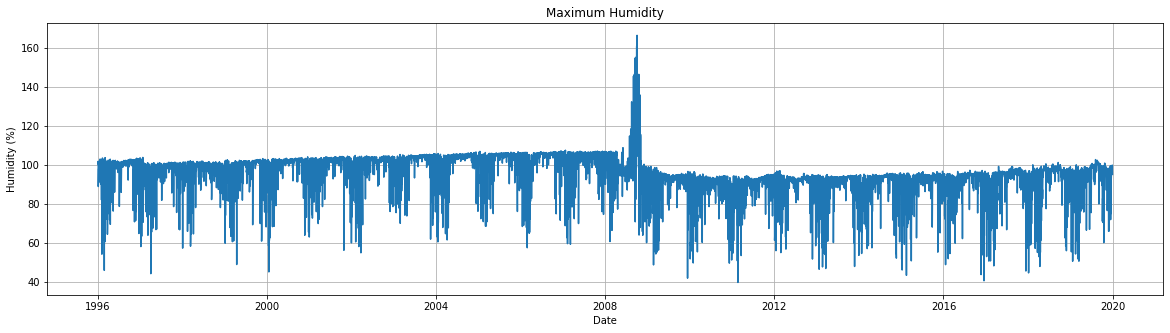

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(weather_data['Date'], weather_data['maxHumPct'])
ax.set(xlabel='Date', ylabel='Humidity (%)', title='Maximum Humidity')
ax.grid()
plt.show()

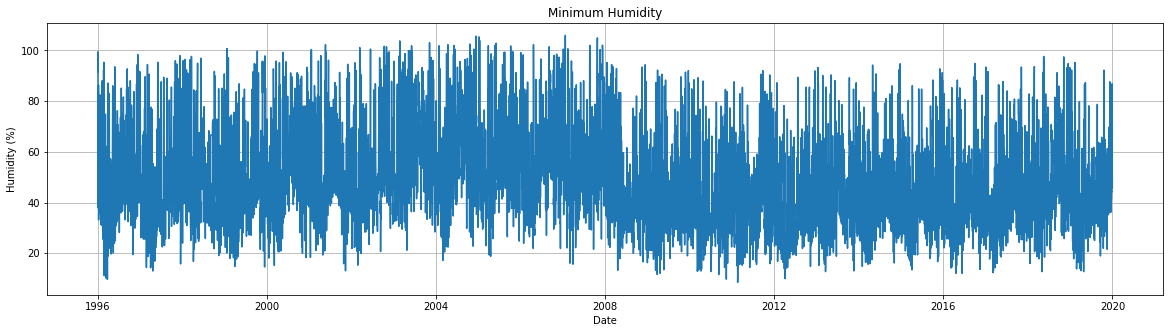

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(weather_data['Date'], weather_data['minHumPct'])
ax.set(xlabel='Date', ylabel='Humidity (%)', title='Minimum Humidity')
ax.grid()
plt.show()

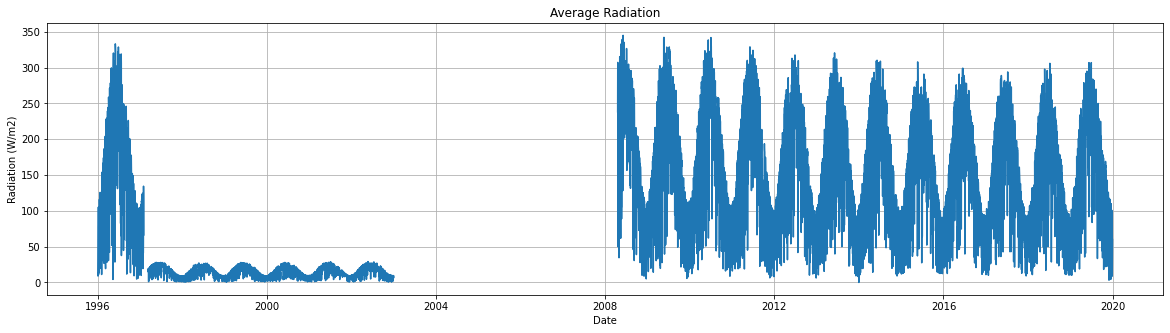

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(weather_data['Date'], weather_data['avgRadWm-2'])
ax.set(xlabel='Date', ylabel='Radiation (W/m2)', title='Average Radiation')
ax.grid()
plt.show()

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(weather_data['Date'], weather_data['meanWindMs-1'])
ax.set(xlabel='Date', ylabel='Wind (m/s)', title='Mean Wind')
ax.grid()
plt.show()

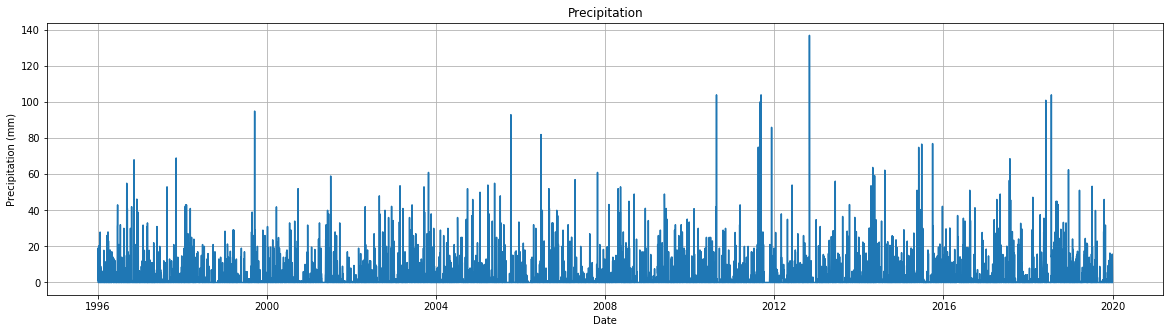

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax.plot(weather_data['Date'], weather_data['PrecipitationMm'])
ax.set(xlabel='Date', ylabel='Precipitation (mm)', title='Precipitation')
ax.grid()
plt.show()

Looking at the graphics, I will not use average radiation because data is missing for years 2003-2008.  I need to check the anomalies for maximum humidity and mean wind and how this can be corrected.

My next step is to work on feature engineering, I will combine crop mangement type in two categories traditional and organic.  After I determine the average number of weeks that takes for each crop to mature I will calculate weather variables weekly average starting from planting date.

I will also calculate growing degree days (GDD) that "are used to estimate the growth and development of plants and insects during the growing season. The basic concept is that development will only occur if the temperature exceeds some minimum development threshold, or base temperature (TBASE). The base temperatures are determined experimentally and are different for each organism". [1]

GDD formula for corn and soybean:

GDD = (Daily Max Temp °C + Daily Min Temp °C) / 2 - 10

GDD formula wheat:

GDD = (Daily Max Temp °C + Daily Min Temp °C) / 2 - 4.4

# References

1. Explanation of Growing Degree Days, Midwestern Regional Climate Center, mrcc.illinois.edu/gismaps/info/gddinfo.htm.
